### Working with true values
To debug the issues with the mock data, the goal here is to analyze the "true" values in the mock data to see if the other issues is with sorting out contaminating data (like the $10M_\odot$ bump). If everything works fine here, then that's most likely the issue. If it still doesn't work here, then there's something deeply wrong with our analysis in general and will need to be revamped almost entirely

In [21]:
import h5py
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy import units as u
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *

sns.set_context('notebook')
sns.set_palette('colorblind')
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'

%matplotlib inline

Let's just start by plotting the mock data in full again, so we know what we're looking at

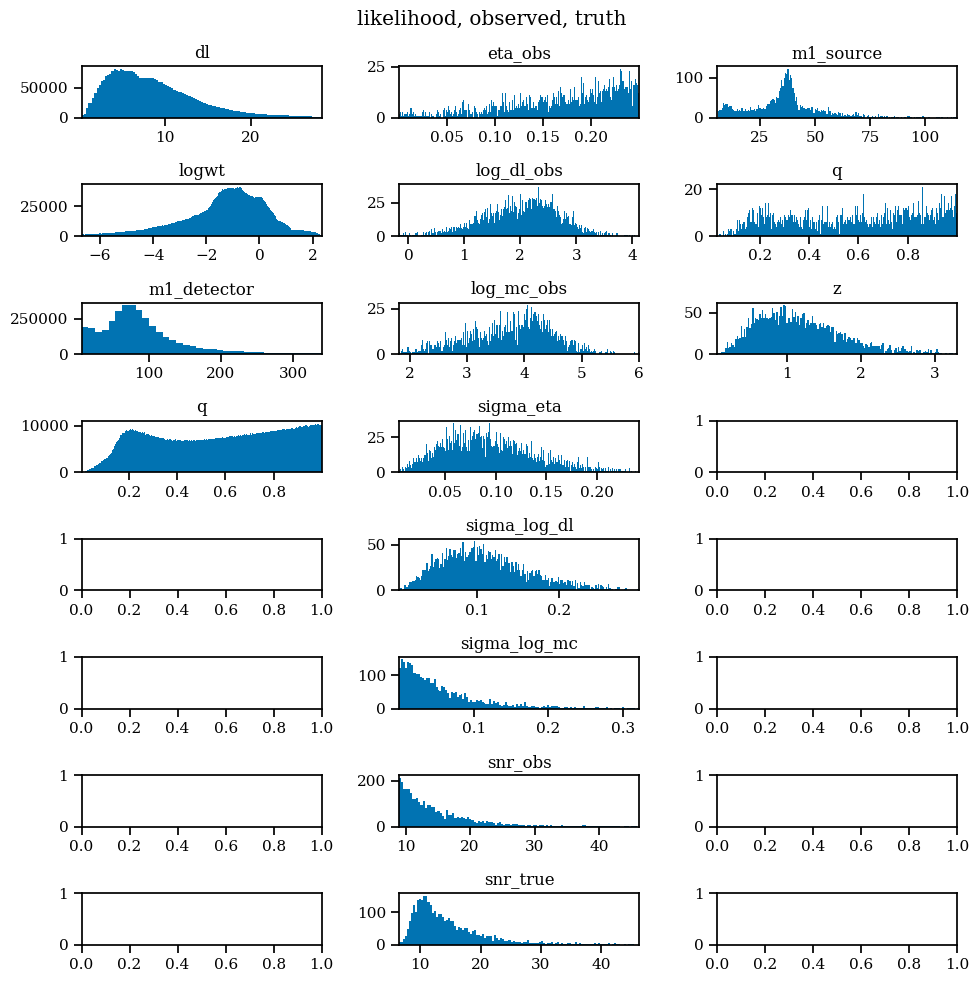

In [22]:
f = "observations.h5"
with h5py.File(f, 'r') as hf:
    keys = list(hf.keys())
    max_len = max([len(list(hf[key])) for key in keys])
    
    fig, axs = subplots(max_len, len(keys), figsize=(10, 10)) #yes I know it's only 3 keys, this keeps it general
    
    for ind_y, key in enumerate(keys):
        params = list(hf[key])
        for ind_x, param in enumerate(params):
            data = array(hf[key][param]).flatten()

            axs[ind_x][ind_y].hist(data, bins=500)
            axs[ind_x][ind_y].set_title(param)
            
            mu = mean(data)
            sigma =std(data)
            up = min(max(data), mu+3*sigma) #upper bound of plot
            low = max(min(data), mu-3*sigma)
            
            axs[ind_x][ind_y].set_xlim(low, up)
    
#     fig.suptitle(sum([str(k) for k in keys]))
    fig.suptitle("likelihood, observed, truth") #This breaks the earlier reason, but the line above didn't work
    fig.tight_layout()


Just going to move some necessary functions in here now from before so they're there when needed:

Now to plot the data and see when the $35M_\odot$ bump actually shows up

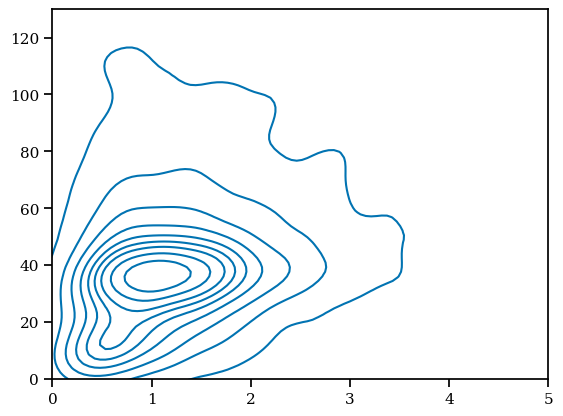

In [23]:
f = "observations.h5"

with h5py.File(f, 'r') as hf:
    ms_true = np.array(hf['truth']['m1_source'])
    zs_true = np.array(hf['truth']['z'])
    
    sns.kdeplot(x=zs_true, y=ms_true)
    plt.xlim(0, 5)
    plt.ylim(0, 130)

That looks pretty flat, but lets do a little more work just to make sure

In [24]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())

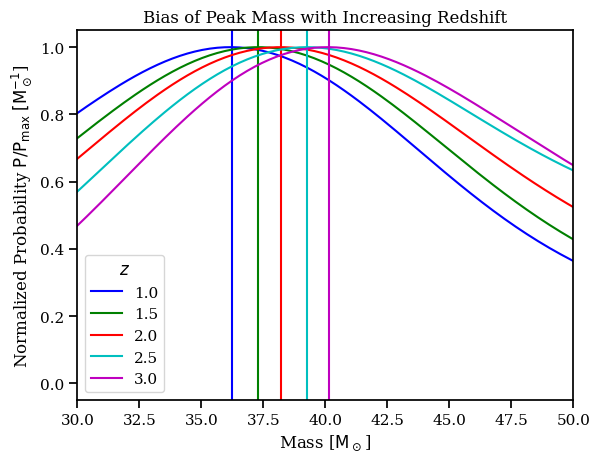

In [26]:
n_z = 5
zmin = 1
zmax = 3
m_max = 60
m_bins = 400
z_slices = np.linspace(zmin, zmax, n_z)
mass_indices = np.linspace(0, m_max, m_bins)

with hf:
    kde = gaussian_kde(np.array([zs_true, ms_true]))
    
    for j, d in enumerate(z_slices):
    
        pdf = [kde.pdf([d, i]) for i in mass_indices]
        ### Dividing by max(pdf) below here to normalize curves
        plt.plot(mass_indices, pdf/max(pdf),c=cmap[j], label=d)
        plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])

    plt.legend(title=r"$z$")
    plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
    plt.ylabel(r"Normalized Probability $\mathrm{P/P_{max}}$ $[\mathrm{M_\odot^{-1}}$]")
    plt.title("Bias of Peak Mass with Increasing Redshift")
    plt.xlim(30, 50)

After playing around with `zmin` and `zmax` for a bit, it looks like the best range is $1 \leq z \leq 3$. However, it is concerning that there is a spread in the "true" peak bump finder. It appears to be a selection effect: smaller BBH mergers aren't detected out at higher redshifts skewing the location of the bump. Let's keep it in that range tough to see if we can still work with it:

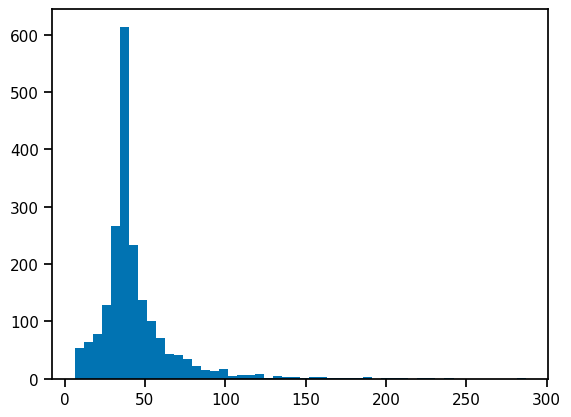

In [6]:
plt.hist(ms_true[(zmin < zs_true) & (zs_true < zmax)], bins=50)
plt.show()

In [7]:
### Sorting out the data that is in the correct redshift range

filtered_ms = ms_true[(zmin < zs_true) & (zs_true < zmax)]
filtered_zs = zs_true[(zmin < zs_true) & (zs_true < zmax)]

print(f'''---------------------------
Original catalog size: %d
Filtered catalog size: %d
---------------------------''' % (len(ms_true), len(filtered_ms)))

print(min(filtered_zs), max(filtered_zs))

---------------------------
Original catalog size: 3643
Filtered catalog size: 2003
---------------------------
1.0000605765948807 2.9980365200134282


In [8]:
n_runs = 15
n_events = len(filtered_ms)
n_zs=10
n_mc = 20
m_min = min(filtered_ms)
m_max = max(filtered_ms)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
z_cent = np.quantile(filtered_zs, np.linspace(0.05, 0.95, n_zs))

ZG, MG = np.meshgrid(z_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_zs))

100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


(0.0, 170.0)

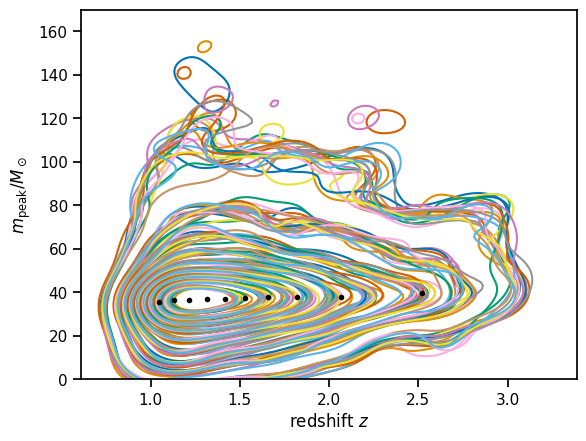

In [9]:
for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m = filtered_ms[events]
    z = filtered_zs[events]
    
    arr = np.array([z, m])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([ZG.ravel(), MG.ravel()])).reshape(ZG.shape)
    for i in range(n_zs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=z, y=m)
    
plt.errorbar(z_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(0, 170)

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

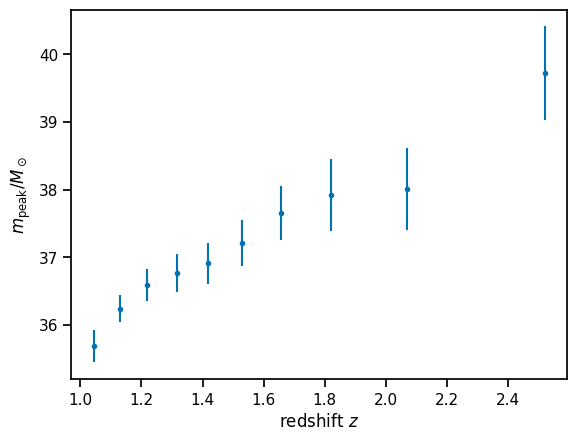

In [10]:
plt.errorbar(z_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.')
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

That's not good at all. Getting close to $z=3$ brings the peak from ~35 to near 40M$_\odot$. Let's see what the MCMC can do with what we still have

In [11]:
print(mpeak_samples)

[[35.75122216 36.1901971  36.41402225 36.48635783 36.73051044 37.35078381
  38.04945233 38.6478056  39.3673194  40.27114936]
 [35.59332943 36.18961764 36.55547179 36.66312166 36.60610521 36.71945361
  37.24674271 38.0445835  38.26103838 38.64783181]
 [35.73313223 36.32324068 36.70670023 36.88263617 36.97995886 37.20008202
  37.80982666 38.58645591 37.10900045 39.212617  ]
 [36.08377732 36.59186498 36.89972567 36.95940477 36.96886979 37.28519347
  37.73577016 37.7663188  38.09404664 38.90318255]
 [35.76519292 36.09982819 36.33712057 36.51181168 36.77811686 37.199725
  37.52169186 37.12975304 37.3156533  38.88977952]
 [36.0198229  36.39144121 36.60521656 36.70824274 36.87440858 37.32753731
  37.88304347 38.22596315 38.67117393 38.89629462]
 [35.32886404 36.11948316 36.73409228 37.09119601 37.17910351 37.42659466
  38.00279678 38.31365597 38.15682801 39.46850317]
 [36.00363349 36.35425766 36.39346688 36.32004077 36.60138898 37.36945979
  38.435919   39.16639077 38.5832411  39.1322389 ]
 [

## Now, to make it like "observed" data to test the MCMC on it

1. Convert source frame mass to detector frame: $M_{det} = M_s(1+z)$
2. Convert redshift to Planck+2018 luminosity distance
3. Sample "true" values like above
4. Run MCMC code through it to see if it works

In [12]:
### Step 1:
m_det = filtered_ms * (1+filtered_zs)

### Step 2:
cosmo = Planck18
d_L = array([float(cosmo.luminosity_distance(i)/u.Mpc) for i in filtered_zs]) # chop off units


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


(0.0, 450.0)

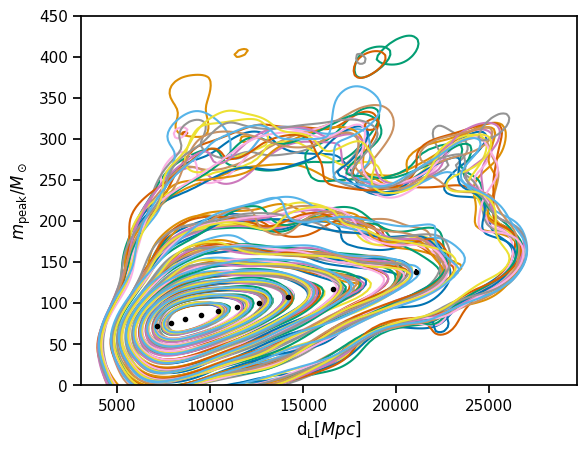

In [13]:
### Step 3:
n_events = len(m_det)
n_dLs=10
n_mc = 20
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(d_L)
dL_max = max(d_L)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(d_L, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    ms = m_det[events]
    d_Ls = d_L[events]
    
    arr = np.array([d_Ls, ms])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls, y=ms)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(0, 450)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 118 seconds.
The acceptance probability does not match the target. It is 0.9952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


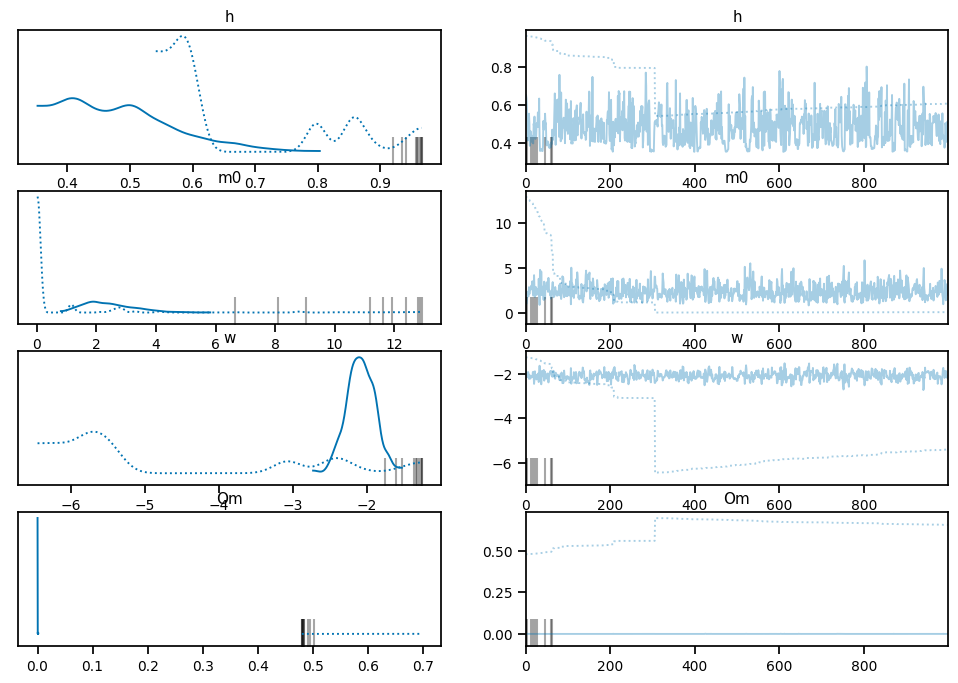

In [14]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)

### Step 4:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

Yikes...That's not good at all. Going now to try in `make-own-data.ipynb` to try mock data without selection effects to see if that's really the issue or if it's something else. Since I don't have that data on hand already, I'll have to make my own, hence the name of the file.